# A4: Linear regression

contents
- prep for linear regression
- linear regression 
- Model testing on Test set
- Model testing on Test set Training set 
- Model testing on Test set adjusted test set

# # Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# activating all columns to be seen:
pd.set_option('display.max_columns', 100)

In [4]:
# activating all rows to be seen:
pd.set_option('display.max_rows', None)

In [5]:
#importing csv dataset:
path = r'C:\Users\chris\Documents\airbnb_Berlin'
listings = pd.read_csv(os.path.join(path,'02 data', 'prepared data', 'listings_details_wrangled.csv'),index_col=False)

In [6]:
listings.head()

,id,scrape_id,last_scraped,source,host_id,host_name,host_location,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,host_location_cleansed,city,country,country_region,Price category
0,3176,20230622195229,2023-06-23,previous scrape,3718,Britta,"Coledale, Australia",Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,4,83.0,63,184,148,4.63,1,0.87,"Coledale, Australia",Coledale,Australia,Australia,Middle price
1,9991,20230622195229,2023-06-23,city scrape,33852,Philipp,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,180.0,6,14,8,5.00,1,0.08,"Berlin, Germany",Berlin,Germany,Germany,High price
2,14325,20230622195229,2023-06-23,city scrape,55531,Chris + Oliver,"Berlin, Germany",Prenzlauer Berg Nordwest,Pankow,52.54813,13.40366,Entire rental unit,Entire home/apt,1,70.0,93,1125,26,4.67,4,0.16,"Berlin, Germany",Berlin,Germany,Germany,Low price
3,16644,20230622195229,2023-06-23,city scrape,64696,Rene,"Santa Cruz, CA",nördliche Luisenstadt,Friedrichshain-Kreuzberg,52.50312,13.43508,Entire condo,Entire home/apt,5,92.0,93,365,48,4.72,2,0.30,"Santa Cruz, CA",Santa Cruz,country unknown,country unknown,Middle price
4,17904,20230622195229,2023-06-23,city scrape,68997,Matthias,"Rio de Janeiro, Brazil",Reuterstraße,Neukölln,52.49419,13.42166,Entire rental unit,Entire home/apt,2,25.0,92,365,299,4.77,1,1.84,"Rio de Janeiro, Brazil",Rio de Janeiro,Brazil,South America,Low price


In [7]:
listings.columns

Index(['id', 'scrape_id', 'last_scraped', 'source', 'host_id', 'host_name',
       'host_location', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'calculated_host_listings_count', 'reviews_per_month',
       'host_location_cleansed', 'city', 'country', 'country_region',
       'Price category'],
      dtype='object')

# Hypothesis

In A2, I found out, that between the number of accommodated people ('accommodates') and the price of the airbnb listing ('price') has a correlation coefficient = 0,44, a medium correlation. The value being rather low with the logic behind it pretty clear (accommodating more people is more costly than few people), there might be further variables to impact the price, like room-type ( a whole apartment is more expensive than a double room). For this first regression analysis, I will focus only on 'accommodates' and 'price'

Hypothesis: The higher the number of accommodated people ('accommodates'), the higher the price ('price').

# Cleaning

In [8]:
# Check for missing values (in my regression columns, this is already the cleaned data set)

listings[['accommodates', 'price']].isnull().sum()

# No missing values to handle

accommodates    0
price           0
dtype: int64

In [9]:
dups = listings.duplicated()

In [10]:
dups.shape # No dups

(12454,)

#### Extreme values checks

C:\Users\chris\AppData\Local\Temp\ipykernel_16428\2288822309.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(listings['price'], bins=40) # Shows extreme values


<Axes: xlabel='price', ylabel='Density'>

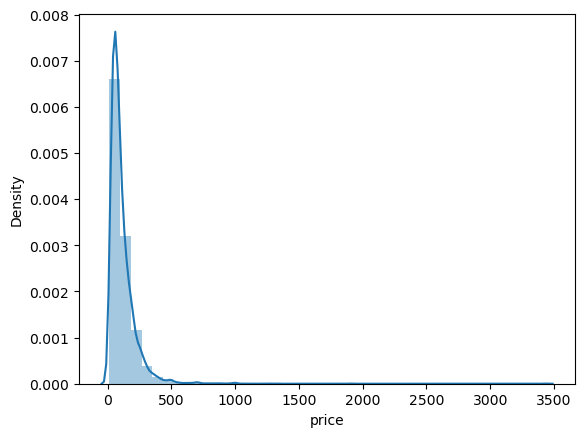

In [11]:
sns.distplot(listings['price'], bins=40) # Shows extreme values

# Some of the outliers in the high values may need to be removed, but let's try without doing so first.

In [12]:
listings['price'].mean() # Check the mean

112.87481933515336

In [13]:
listings['price'].median() # Check the median

81.0

In [14]:
listings['price'].max() # Check the max

3434.0

Outliers in price have already been removed in the first overall cleaning. That outlier was absolutely clear (10,000 a night). Other than that, I didn't remove any 'high' prices, as in a metropole city renting a property has no limit.

## Data prep for regression analysis 

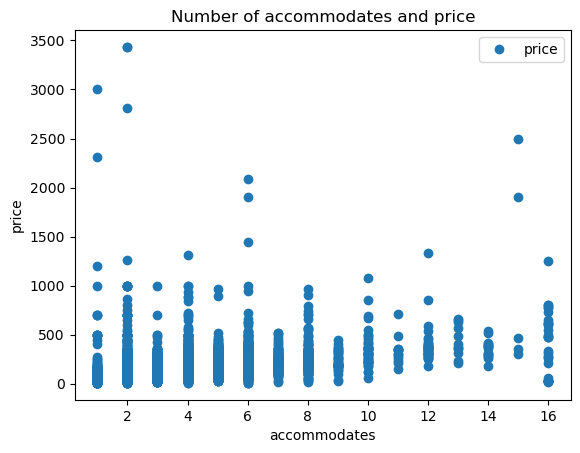

In [15]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.

listings.plot(x = 'accommodates', y='price',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Number of accommodates and price')  
plt.xlabel('accommodates')  
plt.ylabel('price')  
plt.show()

In [16]:
# Reshape the variables into NumPy arrays and put them into separate objects.

X = listings['accommodates'].values.reshape(-1,1)
y = listings['price'].values.reshape(-1,1)

In [17]:
X

array([[4],
       [7],
       [1],
       ...,
       [1],
       [1],
       [2]], dtype=int64)

In [18]:
y

array([[ 83.],
       [180.],
       [ 70.],
       ...,
       [ 55.],
       [ 40.],
       [ 54.]])

In [19]:
# Split data into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Regression analysis

In [20]:
# Create a regression object.

regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [21]:
# Fit the regression object onto the training set.

regression.fit(X_train, y_train)

LinearRegression()

In [22]:
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

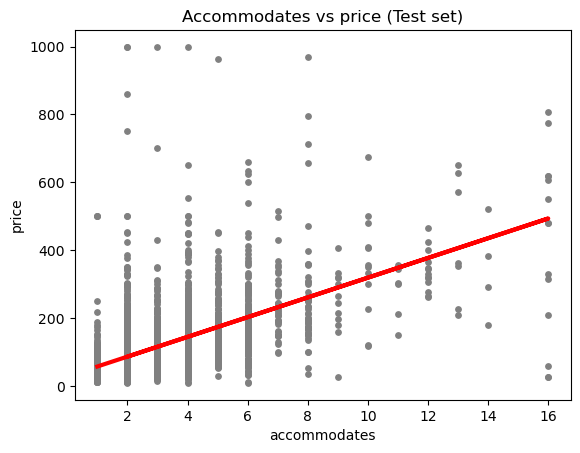

In [23]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Accommodates vs price (Test set)')
plot_test.xlabel('accommodates')
plot_test.ylabel('price')
plot_test.show()

In [24]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score.

In [25]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[29.07692606]]
Mean squared error:  6948.767815609443
R2 score:  0.29195121289246284


In [26]:
y_predicted

array([[ 57.3888895 ],
       [ 86.46581555],
       [144.61966766],
       ...,
       [493.54278034],
       [260.92737189],
       [ 86.46581555]])

### Interpreting the summary statistics above:

Slope: 
- indicates how much the dependent variable changes when the independent variable changes by one unit. 
- slope is approximately 29.08. This means that for each one-unit increase in your independent variable (X), there is an estimated increase of about 29.08 units in the dependent variable (Y).

Mean Squared Error (MSE): 
- are the average squared difference between the observed values (your data) and the predicted values from the regression. - A lower MSE indicates that the regression line fits the data well. 
- In the case above case, the MSE is 6948.77. With the max-value in the model being around 1000, this is a rather large deviation.

R2 Score (Coefficient of Determination): 
- The R2 score still provides insight into how well the independent variable (X) explains the variations in the dependent variable (Y) on the test data. 
- An R2 score of 0.29 means that approximately 29% of the variance in Y is explained by your independent variable X on the test data.

Overall, this interpretation suggests that the model struggles to cover the full range of the dependent variable Y, especially when the maximum value in the model is around 1000, while the entire dataset has a maximum value of approximately 3500. This implies that additional factors or a more complex modeling approach may be necessary to achieve better predictions for Y.

This fits my assumptions I related in my Hypothesis. 

In [27]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,46.0,57.388889
1,67.0,86.465816
2,106.0,144.619668
3,128.0,86.465816
4,145.0,57.388889
5,115.0,86.465816
6,425.0,86.465816
7,30.0,57.388889
8,100.0,86.465816
9,98.0,144.619668


#### We can see that there is mostly a huge difference in the actual and the predicted values.

## Checking the model on the training set (as opposed to the test set)

##### Compare how the regression fits the training set:

In [28]:
# Predict.

y_predicted_train = regression.predict(X_train) # This is predicting X_train!

In [29]:
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

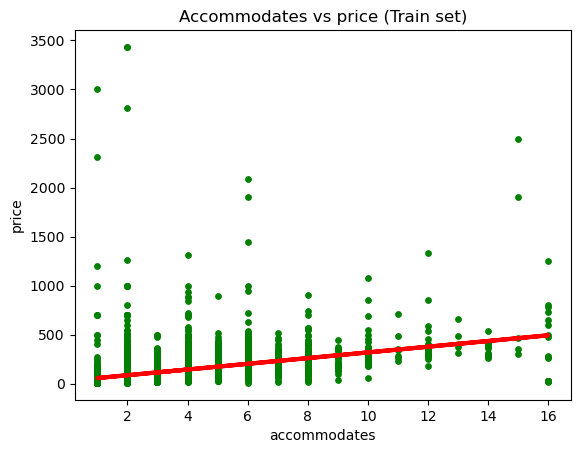

In [30]:
# Visualizing the training set results.

plot_test = plt
plot_test.scatter(X_train, y_train, color='green', s = 15)
plot_test.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_test.title('Accommodates vs price (Train set)')
plot_test.xlabel('accommodates')
plot_test.ylabel('price')
plot_test.show()

In [31]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[29.07692606]]
Mean squared error:  14031.780879784877
R2 score:  0.17121971290689353


Some things catch my eye:
- The R2-score in the train set is LOWER than in the test set!
- But still: The summary stats repeat it, the regression model struggles and is not a good fit. 

- That means: Either there is no linear correlation, or there are other determinating variables to be considered in the model or excluded from the model

### Bonus: performance improvement after removing outliers

In [32]:
# the room type will be one of the stronger disturbers of my model. >> MIN
room_type_avg_price = listings.groupby('room_type')['price'].min().round(1)
print(room_type_avg_price)

room_type
Entire home/apt    10.0
Hotel room         59.0
Private room        8.0
Shared room        10.0
Name: price, dtype: float64


In [33]:
# the room type will be one of the stronger disturbers of my model. >> MAX
room_type_avg_price = listings.groupby('room_type')['price'].max().round(1)
print(room_type_avg_price)

room_type
Entire home/apt    3434.0
Hotel room          738.0
Private room       2088.0
Shared room        2310.0
Name: price, dtype: float64


In [34]:
# the room type will be one of the stronger disturbers of my model. >> MEAN
room_type_avg_price = listings.groupby('room_type')['price'].mean().round(1)
print(room_type_avg_price)

room_type
Entire home/apt    133.5
Hotel room         231.2
Private room        67.6
Shared room        102.7
Name: price, dtype: float64


In [35]:
# the room type will be one of the stronger disturbers of my model. >> MEDIAN
room_type_avg_price = listings.groupby('room_type')['price'].median().round(1)
print(room_type_avg_price)

room_type
Entire home/apt    100.0
Hotel room         199.5
Private room        48.0
Shared room         53.0
Name: price, dtype: float64


In [36]:
listings['room_type'].value_counts()

Entire home/apt    8138
Private room       4020
Shared room         162
Hotel room          134
Name: room_type, dtype: int64

 #### The entire apartment has a min close to private rooms. I will take the mean value of entire apartment as my new 'outlier' variable. This rules out a lot of hotel rooms and apartments, leaving more private rooms. If I'm right, the model shoul be a better fit. In a next step, I could make separate predictions on subsets after room_type.

In [37]:
# Clean the 'price' values. Below 600 is randomly chosen, but it will remove many of the higher values that are due to room-type entire apartment.
df_test = listings[listings['price'] <=600] 

In [38]:
df_test.describe() # checking the max price. 

,id,scrape_id,host_id,latitude,longitude,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month
count,1.237100e+04,1.237100e+04,1.237100e+04,12371.000000,12371.000000,12371.000000,12371.000000,12371.000000,12371.000000,12371.000000,10027.000000,12371.000000,10027.000000
mean,1.849950e+17,2.023062e+13,1.323307e+08,52.509798,13.402575,2.933231,106.799046,43.915690,666.644653,36.689677,4.679704,7.147037,1.125511
std,3.270219e+17,2.461037e+00,1.544417e+08,0.033458,0.066328,1.824358,82.860423,47.494826,497.271481,78.776087,0.618868,22.447635,1.864223
min,3.176000e+03,2.023062e+13,1.581000e+03,52.369040,13.107580,1.000000,8.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.010000
25%,1.514790e+07,2.023062e+13,1.272474e+07,52.490185,13.363287,2.000000,50.000000,2.000000,130.000000,1.000000,4.620000,1.000000,0.120000
50%,3.433614e+07,2.023062e+13,5.274744e+07,52.509840,13.411690,2.000000,80.000000,7.000000,1124.000000,7.000000,4.840000,1.000000,0.480000
75%,5.422123e+07,2.023062e+13,2.152014e+08,52.532337,13.438070,4.000000,139.000000,92.000000,1125.000000,34.000000,5.000000,3.000000,1.540000
max,9.188887e+17,2.023062e+13,5.211785e+08,52.656110,13.721390,16.000000,600.000000,365.000000,9999.000000,2074.000000,5.000000,172.000000,65.330000


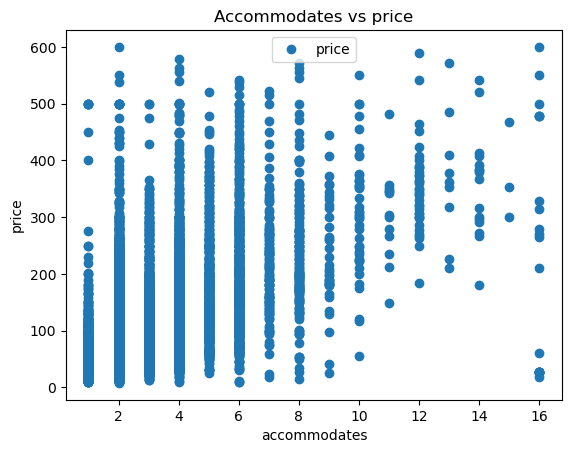

In [39]:
# See how the scatterplot looks without outliers.

df_test.plot(x = 'accommodates', y='price', style='o')  
plt.title('Accommodates vs price')  
plt.xlabel('accommodates')  
plt.ylabel('price')  
plt.show()

In [40]:
# Reshape again.

X_2 = df_test['accommodates'].values.reshape(-1,1)
y_2 = df_test['price'].values.reshape(-1,1)

In [41]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=0)

In [42]:
# Run and fit the regression.

regression = LinearRegression()  
regression.fit(X_train_2, y_train_2)

LinearRegression()

In [43]:
# Predict.

y_predicted_2 = regression.predict(X_test_2)

In [44]:
rmse = mean_squared_error(y_test_2, y_predicted_2)
r2 = r2_score(y_test_2, y_predicted_2)

In [45]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[25.38073511]]
Mean squared error:  4916.2958896757555
R2 score:  0.29014154542465886


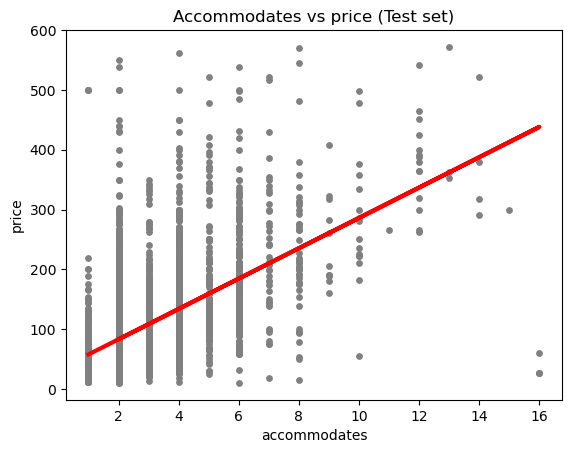

In [46]:
# Visualizing the test set results.
plot_test = plt
plot_test.scatter(X_test_2, y_test_2, color='gray', s = 15)
plot_test.plot(X_test_2, y_predicted_2, color='red', linewidth =3)
plot_test.title('Accommodates vs price (Test set)')
plot_test.xlabel('accommodates')
plot_test.ylabel('price')
plot_test.show()

In [47]:
data = pd.DataFrame({'Actual': y_test_2.flatten(), 'Predicted': y_predicted_2.flatten()})
data.head(30)

,Actual,Predicted
0,23.0,57.603883
1,197.0,133.746089
2,84.0,108.365354
3,25.0,82.984619
4,62.0,82.984619
5,60.0,82.984619
6,159.0,133.746089
7,30.0,82.984619
8,55.0,82.984619
9,22.0,82.984619


In [48]:
data.describe() # comparing the values

,Actual,Predicted
count,3712.000000,3712.000000
mean,106.837554,106.409834
std,83.232250,45.788413
min,10.000000,57.603883
25%,50.000000,82.984619
50%,80.000000,82.984619
75%,140.000000,133.746089
max,572.000000,438.314910


### conclusions after adjusted model
The values are comparable with the first iteration of the regression model, especially the R2-Value with 0.29. Either the correlation is not linear or there are other factors. 

#### Reflections on possible data bias

Human Error: Landlords list their listings and set a price. If there is a zero less or more makes a difference. OR a landlord sets a price that is way too high or too low for other reasons like poor understanding of the local markets. Since the data is web-scraped and there is no authority checking if all prices are correctly entered, there is no way to rule that out. Chances are low, of course, because price is the most important information.

It's not the same with number of accommodated people or room-type. Landlords might add a few people for a rather small property, just to increase the possible price. As we saw in earlier submissions, the number of beds and number of accommodates is not the same. So, this might be more of a problem, but no way to fix it, either.